In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import numpy as np

['mnist_test.csv', 'mnist_train.csv']

In [4]:
class MnistDataset(Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file, header=None)
        self.labels = torch.tensor(self.data.iloc[:, 0].values)
        self.features = torch.tensor(self.data.iloc[:, 1:].values, dtype=torch.float32)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, 10)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

In [5]:
batch_size = 64
test_batch_size = 1000
train_data_file = open("mnist_dataset/mnist_train.csv", 'r')
train_dataset = MnistDataset(train_data_file)
train_data_file.close()
test_data_file = open("mnist_dataset/mnist_test.csv", 'r')
test_dataset = MnistDataset(test_data_file)
test_data_file.close()
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=test_batch_size, shuffle=False)

seed = 1
torch.manual_seed(seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)

In [4]:
def taskresponsetrain(model, device, train_loader):
    model.eval()
    hout = [[] for _ in range(10)]
    with torch.no_grad():
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            # 取得隐藏层的输出
            houtput = F.relu(model.fc1(data))
            houtput = F.sigmoid(model.fc2(houtput))
            output = model.fc3(houtput)
            houtput = houtput.cpu().tolist()
            for i, t in enumerate(target):
                if output[i].argmax() == t: # 只取预测正确的
                    hout[t].append(houtput[i])
    return hout

In [7]:
model.load_state_dict(torch.load("mnist_nn.pth"))
hout = taskresponsetrain(model, device, train_loader)
hout = np.array(hout, dtype=object)
np.save("hout_mnist_train.npy", hout)

In [10]:
def taskresponsetest(model, device, test_loader):
    model.eval()
    hout = [[] for _ in range(10)]
    cor = []
    cali = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            # 取得隐藏层的输出
            houtput = F.relu(model.fc1(data))
            houtput = F.sigmoid(model.fc2(houtput))
            output = F.softmax(model.fc3(houtput), dim=1)
            houtput = houtput.cpu().tolist()
            for i, t in enumerate(target):
                y = output[i].argmax()
                correct = (y==t).cpu()
                hout[y].append(houtput[i]+[correct])
                cor.append(correct.item())
                cali.append(output[i].max().item())
    return hout, cor, cali

In [11]:
model.load_state_dict(torch.load("mnist_nn.pth"))
hout, cor, cali = taskresponsetest(model, device, test_loader)

In [12]:
hout = np.array(hout, dtype=object)
np.save("hout_mnist_test.npy", hout)

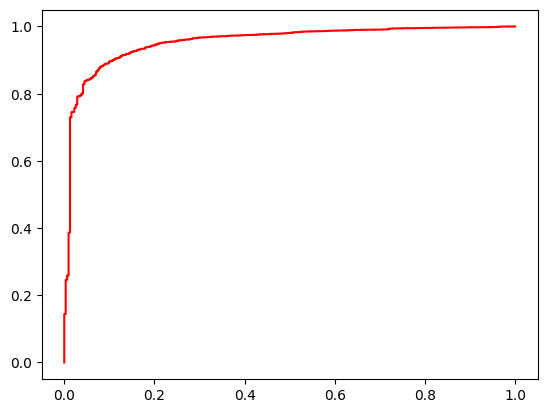

0.9549072882170401

In [13]:
#ROC，AUROC
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(cor, cali)
roc_auc = roc_auc_score(cor, cali)
plt.plot(fpr, tpr, color='r', linestyle='-')
plt.show()
roc_auc